In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
from model import sampling_rnn
import numpy as np

from helpers import get_sequences, iterate_minibatches, get_minibatches

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

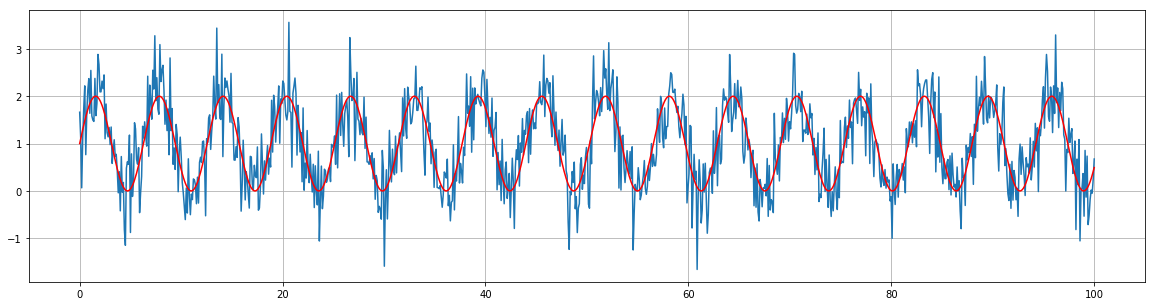

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
# split it to train and test
slice_ind = int(n_samples*0.7)
# clear up namings for modeling
plot_train_x, train_x, plot_test_x, test_x, smooth_train_x, smooth_test_x = [x[:slice_ind], y[:slice_ind], 
                                                                             x[slice_ind:], y[slice_ind:], 
                                                                             smooth[:slice_ind], smooth[slice_ind:]]

# train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
# train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 5
train_x = get_sequences(train_x, seq_len, 1)

In [5]:
train_x.shape

(140, 5, 1)

In [6]:
test_x.shape

(300,)

#### So we observe the drift from lstm if it were to generate actual predictions
we employ a different training scheme in the model sampling_rnn

In [8]:
%%time
tf.reset_default_graph()

batch_size = 32
# n_batches = train_x.shape[0]//batch_size
state_size = 100


# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)



# inputs = tf.placeholder(shape=(max_time, batch_size, input_depth),
#                         dtype=tf.float32)

# input 
X = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'output')

output, last_states = sampling_rnn(cell=lstm_cell, 
                                   initial_state=initial_state, 
                                   input_=X,
                                   seq_lengths=seq_len)
# output as the prediction
pred = tf.reshape(output, (batch_size, seq_len, 1))
# loss
# shift to create next time step
# label = tf.manip.roll(Y, 1, axis=0)
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))
# loss
loss = tf.losses.mean_squared_error(Y, pred)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)

# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
printn = 1e2
for i in range(1000):
    epoch_loss =0.
    for batch in iterate_minibatches(train_x, np.roll(train_x, 1), batch_size, shuffle=False):
        train_xi, train_yi = batch
        p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_xi, Y: train_yi})
        epoch_loss += l
        
    if i%printn ==0:
        print('Epoch {0:} | loss: {1:.2f}'.format(i, epoch_loss))

before return in sampling_rnn=========================

label shape:(32, 5, 1) | output prediction shape: (32, 5, 1)
Epoch 0 | loss: 7.16
Epoch 100 | loss: 1.48
Epoch 200 | loss: 1.48
Epoch 300 | loss: 1.47
Epoch 400 | loss: 1.46
Epoch 500 | loss: 1.45
Epoch 600 | loss: 1.44
Epoch 700 | loss: 1.44
Epoch 800 | loss: 1.44
Epoch 900 | loss: 1.43
Wall time: 16.9 s


#### Test model

In [10]:
# make test set
test_x = get_sequences(test_x, seq_len, 1)
# randomly choose some test segment
# test_ind = np.random.randint(0, test_x.shape[0]-batch_size-1)
test_ind = 0
assert test_ind < test_x.shape[0]-batch_size-1, print('index is out of test set range with length ', len(test_x), test_x.shape[0]-batch_size-1)
ctest_x = test_x[test_ind:test_ind+batch_size, :, :]

In [11]:
# make plot test set
plot_test_x = get_sequences(plot_test_x, seq_len, 1)
plot_ctest_x = plot_test_x[test_ind:test_ind+batch_size, :, :]
plot_ctest_x = plot_ctest_x.reshape(-1)

In [12]:
# test_x, test_y = get_minibatches(test_x, np.roll(test_x, 1), 32)

In [13]:
test_pred = sess.run([output], feed_dict={X: ctest_x})[0]
test_pred = test_pred.reshape(-1)

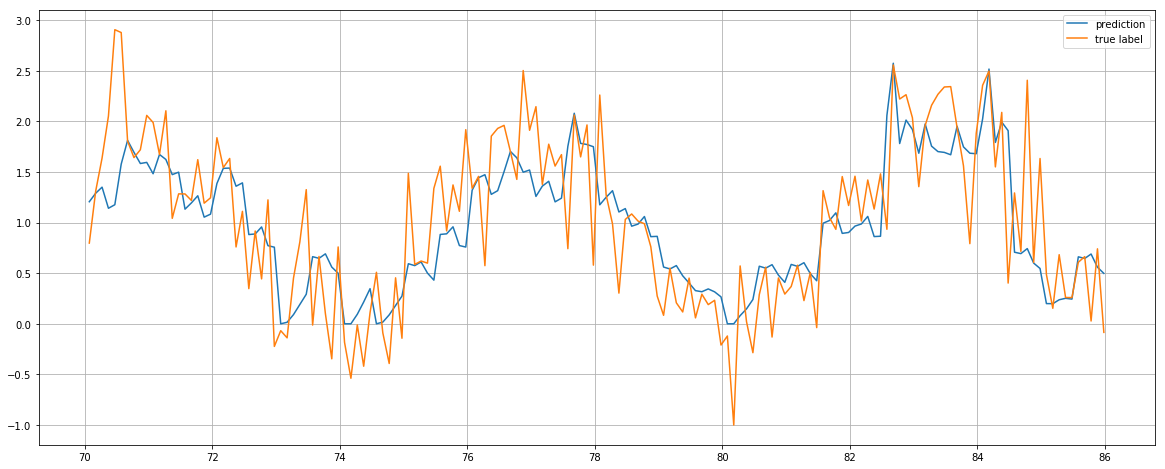

In [14]:
plt.figure(figsize=(20,8))
plt.plot(plot_ctest_x, test_pred, plot_ctest_x, np.roll(ctest_x.reshape(-1), 1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)

#### Generate true prediction instead of relying on true input

In [15]:
test_x.shape

(60, 5, 1)

In [16]:
%%time
import copy

# define how many sequences we want to generate
# gen_len = 20
# assert gen_len < test_y.shape[0], 'sequence to be generated out of range'
# test_y1 = copy.deepcopy(test_y[:gen_len])

test_x_fake = np.zeros(test_x.shape)+1e3
# we only need the first element as input
# test_x_fake[0,0,0] = test_x[0,0,0]
fake_x, fake_y = get_minibatches(test_x_fake, np.roll(test_x,1), batch_size, shuffle=False)
_, true_x = get_minibatches(test_x_fake, test_x, batch_size, shuffle=False)

print('fake_x shape:', fake_x.shape)
fake_result = []
for i in range(fake_x.shape[0]):
    print(i)
    fake_x[i][:, 0, 0] = true_x[i][:, 0, 0]
#     print(fake_x[i])
    for j in range(batch_size):
        for k in range(seq_len-1):
            pred_i = sess.run([pred], feed_dict={X: fake_x[i]})[0]
            fake_x[i][j][k+1] = pred_i[j][k]
    fake_result.append(pred_i)
gen_result = np.array(fake_result).reshape(-1)
print(gen_result.shape)

fake_x shape: (1, 32, 5, 1)
0
(160,)
Wall time: 298 ms


In [17]:
i

0

In [18]:
plot_test_x.shape

(60, 5, 1)

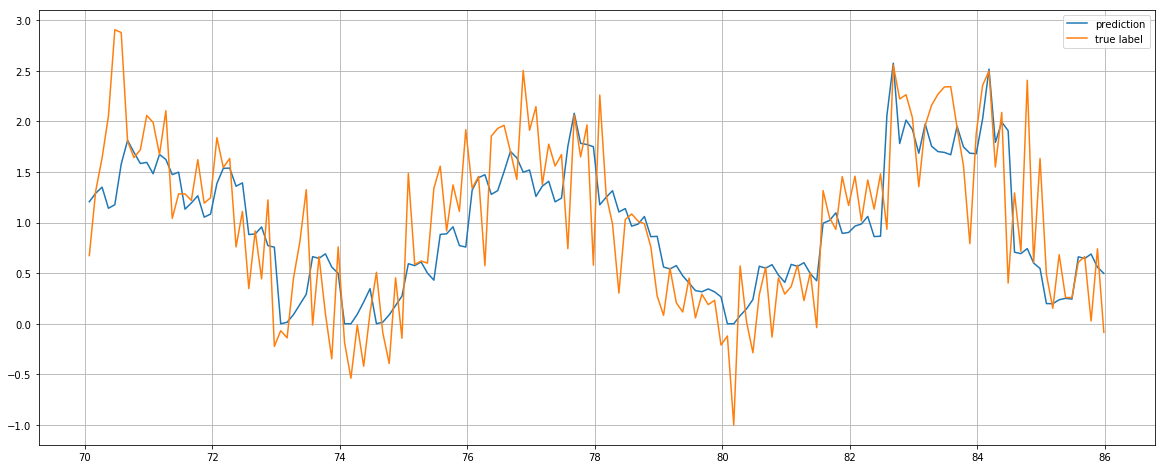

In [19]:
plt.figure(figsize=(20,8))
plot_test_x = plot_test_x[0:batch_size*fake_x.shape[0], :, :]
plot_test_x = plot_test_x.reshape(-1)
plt.plot(plot_test_x, gen_result, plot_test_x, fake_y.reshape(-1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)

this matches with what we have in regular test stage, which means the model indeed doesn't rely on the next time step true input, however, notice this is not the true sequence generation as this only self generates for the length of sequence length